In [43]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import colorsys
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

In [2]:
import os
import sys
module_path = os.path.abspath('/mnt/c/Users/demeter_turos/PycharmProjects/chrysalis')
if module_path not in sys.path:
    sys.path.append(module_path)

import chrysalis as ch

plt.rcParams['svg.fonttype'] = 'none'

data_path = '/mnt/c/Users/demeter_turos/PycharmProjects/chrysalis/data/fig_2/'

In [ ]:
adata = sc.datasets.visium_sge(sample_id='V1_Mouse_Brain_Sagittal_Anterior')

sc.pp.calculate_qc_metrics(adata, inplace=True)
sc.pp.filter_cells(adata, min_counts=1000)
sc.pp.filter_genes(adata, min_cells=10)

sc.pl.spatial(adata, img_key="hires", color="total_counts", size=1.8, cmap='viridis')

ch.detect_svgs(adata, min_morans=0.05, min_spots=0.05)
adata.write(data_path + 'chr_anterior_morgane.h5ad')

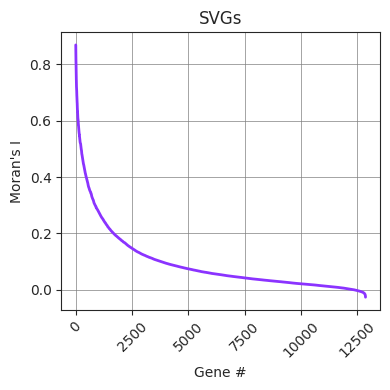

In [12]:
adata = sc.read_h5ad(data_path + 'chr_anterior.h5ad')

ch.plot_svgs(adata)
plt.show()

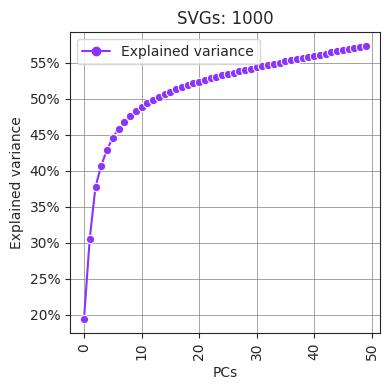

In [13]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

ch.pca(adata, n_pcs=50)
ch.aa(adata, n_pcs=20, n_archetypes=28)

ch.plot_explained_variance(adata)
plt.show()

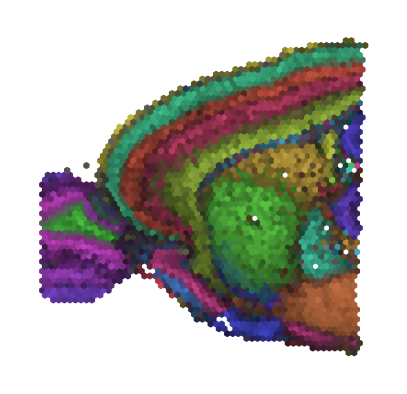

In [14]:
ch.plot(adata, dim=28)
plt.show()

In [15]:
ground_truth = pd.read_csv(data_path + 'anterior_ground_truth.tsv', index_col=0,
                           sep='\t')
ground_truth = ground_truth.iloc[:, 3:]

for gt in ground_truth.columns:
    adata.obs['ground_truth'] = ground_truth[gt]
    nrgns = len(np.unique(adata.obs['ground_truth']))

adata.obs['ground_truth'] = ground_truth['ground_truth_4']

In [22]:
def generate_random_colors(num_colors, hue_range=(0, 1), saturation=0.5, lightness=0.5, min_distance=0.05, seed=None):
    colors = []
    hue_list = []
    if seed:
        np.random.seed(seed)
    else:
        np.random.seed(42)
    while len(colors) < num_colors:
        # generate a random hue value within the specified range
        hue = np.random.uniform(hue_range[0], hue_range[1])

        # check if the hue is far enough away from the previous hue
        if len(hue_list) == 0 or all(abs(hue - h) > min_distance for h in hue_list):
            hue_list.append(hue)
            saturation = saturation
            lightness = lightness
            rgb = colorsys.hls_to_rgb(hue, lightness, saturation)
            hex_code = '#{:02x}{:02x}{:02x}'.format(int(rgb[0] * 255), int(rgb[1] * 255), int(rgb[2] * 255))
            colors.append(hex_code)

    return colors


c_list = []
for i in range(adata.obsm['chr_aa'].shape[1]):
    c_name = f'C {i}'
    c_list.append(c_name)
    adata.obs[c_name] = adata.obsm['chr_aa'][:, i]

cortex_annot = [x for x in np.unique(adata.obs['ground_truth']) if '::L' in x]

for e in ['HY::LPO', 'AON::L1_1', 'AON::L1_2', 'AON::L2']:
    cortex_annot.remove(e)

order = ['FRP::L1', 'MO::L1', 'ORB::L1', 'SS::L1', 'FRP::L2/3', 'MO::L2/3', 'ORB::L2/3',
         'SS::L2/3', 'MO::L5', 'ORB::L5', 'SS::L5', 'MO::L6', 'ORB::L6', 'SS::L6']

long_df = pd.melt(adata.obs,
                  value_vars=c_list,
                  id_vars=['ground_truth'])

long_df = long_df[long_df['ground_truth'].isin(cortex_annot)]

long_df['ground_truth'] = pd.Categorical(long_df['ground_truth'], categories=order, ordered=True)
long_df = long_df.sort_values('ground_truth')

# sort the DataFrame based on the categorical column

long_df = long_df[long_df['variable'].isin(['C 4', 'C 15', 'C 8',
                                            'C 1', 'C 11'])]

hexcodes = generate_random_colors(num_colors=28, min_distance=1 / 28 * 0.5)
hexcodes = [hexcodes[x] for x in [4, 15, 8, 1, 11]]

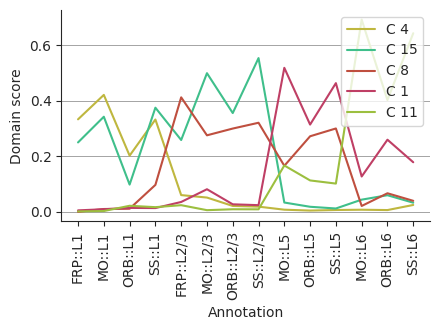

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(6*0.75, 4*0.85))
sns.lineplot(long_df, x='ground_truth', y='value', hue='variable', sort=False, ax=ax, orient='x',
             palette=hexcodes, hue_order=['C 4', 'C 15', 'C 8', 'C 1', 'C 11'], errorbar=None)
ax.grid(axis='y', linestyle='-', linewidth='0.5', color='grey')
ax.set_axisbelow(True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.legend(loc = 'upper right', title='')
ax.set_xlabel('Annotation')
ax.set_ylabel('Domain score')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
# plt.savefig('/mnt/c/Bern/Docs/chrysalis/figs/svgs/fig_2_brain_domain_scores_90.svg')
plt.show()

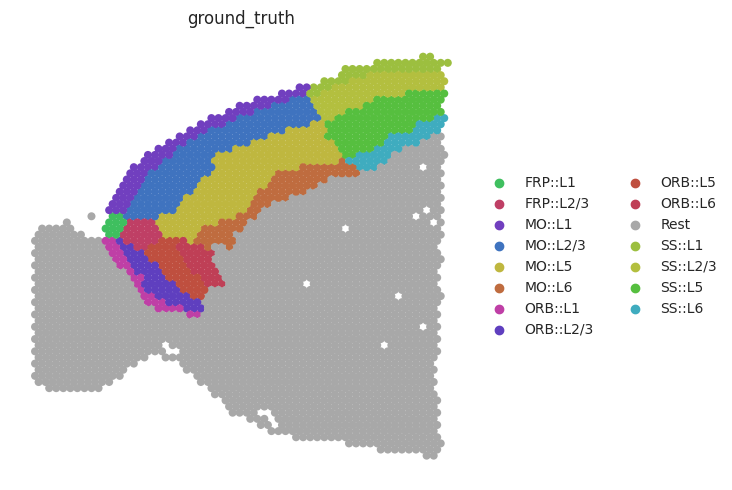

In [24]:
adata.obs['ground_truth'] = [x if x in cortex_annot else 'Rest' for x in adata.obs['ground_truth']]

hexcodes = generate_random_colors(num_colors=28, min_distance=1 / 28 * 0.5)
hexcodes[10] = '#a8a8a8'

fig, ax = plt.subplots(1, 1, figsize=(9, 5))
sc.pl.spatial(adata, color=['ground_truth'], size=1.75, show=False, ax=ax,
              alpha_img=0, frameon=False, palette=hexcodes)
plt.tight_layout()
plt.show()

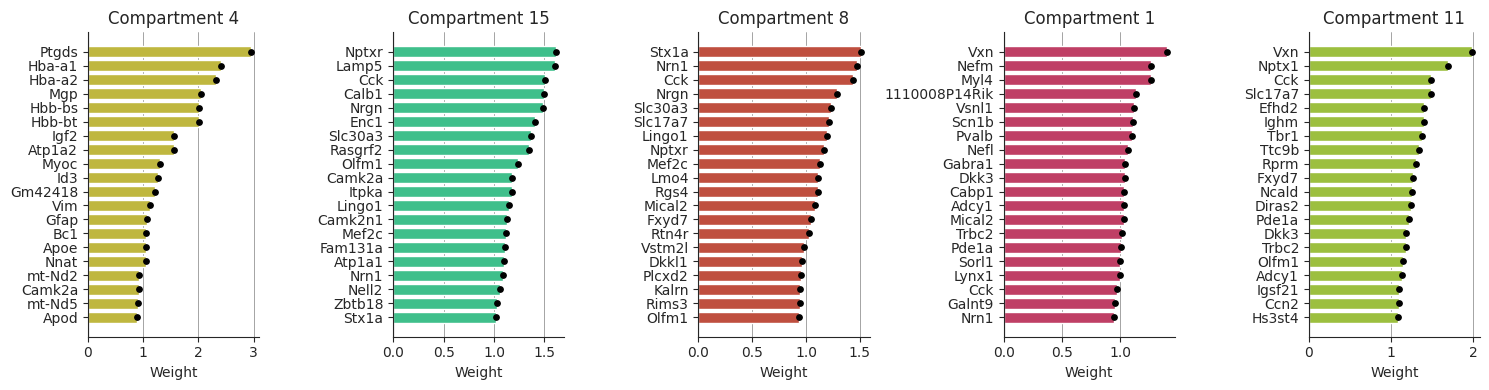

In [26]:
ch.plot_weights(adata, compartments=[4, 15, 8, 1, 11], ncols=5)
plt.show()

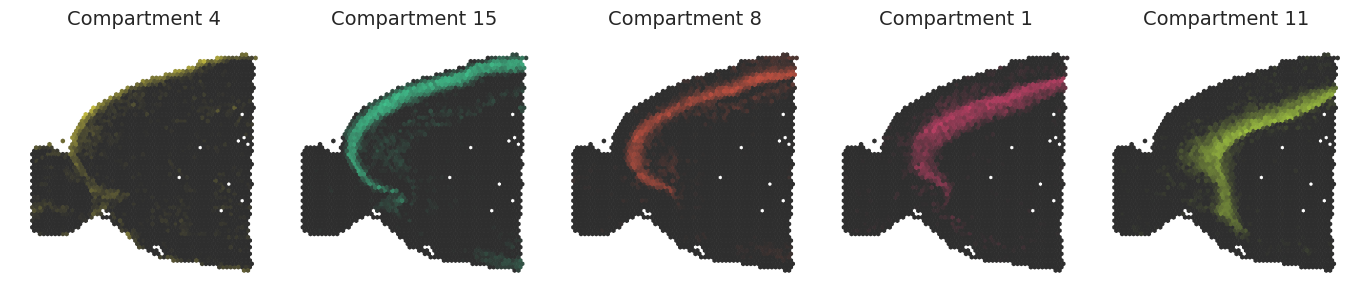

In [36]:
fig, axs = plt.subplots(1, 5, figsize=(15, 4))
axs = axs.flatten()
for a in axs:
    a.axis('off')
plt.subplots_adjust(hspace=0.05, wspace=0.01, left=0.05, right=0.95, top=0.95, bottom=0.05)
for i, dim in enumerate([4, 15, 8, 1, 11]):
    ch.plot_compartment(adata, fig, axs[i], dim=28, selected_dim=dim, color_first='#2e2e2e', spot_size=0.85,
                   rasterized=True)
    axs[i].set_title(f'Compartment {dim}', size=14)
plt.show()


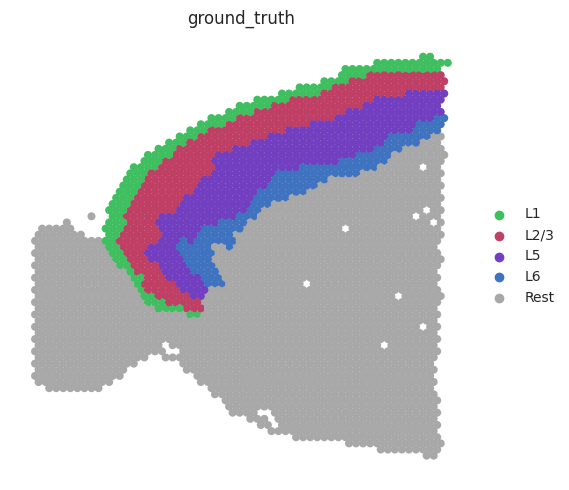

In [32]:
adata.obs['ground_truth'] = [x.split('::')[-1] if x in cortex_annot else 'Rest' for x in adata.obs['ground_truth']]

hexcodes = generate_random_colors(num_colors=5, min_distance=1 / 5 * 0.5)
hexcodes[4] = '#a8a8a8'

fig, ax = plt.subplots(1, 1, figsize=(9, 5))
sc.pl.spatial(adata, color=['ground_truth'], size=1.75, show=False, ax=ax,
              alpha_img=0, frameon=False, palette=hexcodes)
plt.tight_layout()
plt.show()

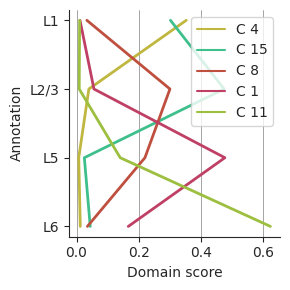

In [31]:
adata.obs['ground_truth'] = ground_truth['ground_truth_4']

c_list = []
for i in range(adata.obsm['chr_aa'].shape[1]):
    c_name = f'C {i}'
    c_list.append(c_name)
    adata.obs[c_name] = adata.obsm['chr_aa'][:, i]

cortex_annot = [x for x in np.unique(adata.obs['ground_truth']) if '::L' in x]

for e in ['HY::LPO', 'AON::L1_1', 'AON::L1_2', 'AON::L2']:
    cortex_annot.remove(e)

long_df = pd.melt(adata.obs,
                  value_vars=c_list,
                  id_vars=['ground_truth'])

long_df = long_df[long_df['ground_truth'].isin(cortex_annot)]

long_df['ground_truth'] = [x.split('::')[-1] for x in long_df['ground_truth']]
order = ['L1', 'L2/3','L5', 'L6']

long_df['ground_truth'] = pd.Categorical(long_df['ground_truth'], categories=order, ordered=True)
long_df = long_df.sort_values('ground_truth')

# sort the DataFrame based on the categorical column

long_df = long_df[long_df['variable'].isin(['C 4', 'C 15', 'C 8',
                                            'C 1', 'C 11'])]

hexcodes = generate_random_colors(num_colors=28, min_distance=1 / 28 * 0.5)
hexcodes = [hexcodes[x] for x in [4, 15, 8, 1, 11]]

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
sns.lineplot(long_df, y='ground_truth', x='value', hue='variable', sort=False, ax=ax, orient='y',
             palette=hexcodes, hue_order=['C 4', 'C 15', 'C 8', 'C 1', 'C 11'], errorbar=None,
             linewidth=2)
ax.grid(axis='x', linestyle='-', linewidth='0.5', color='grey')
ax.set_axisbelow(True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.legend(loc = 'upper right', title='')
ax.set_ylabel('Annotation')
ax.set_xlabel('Domain score')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

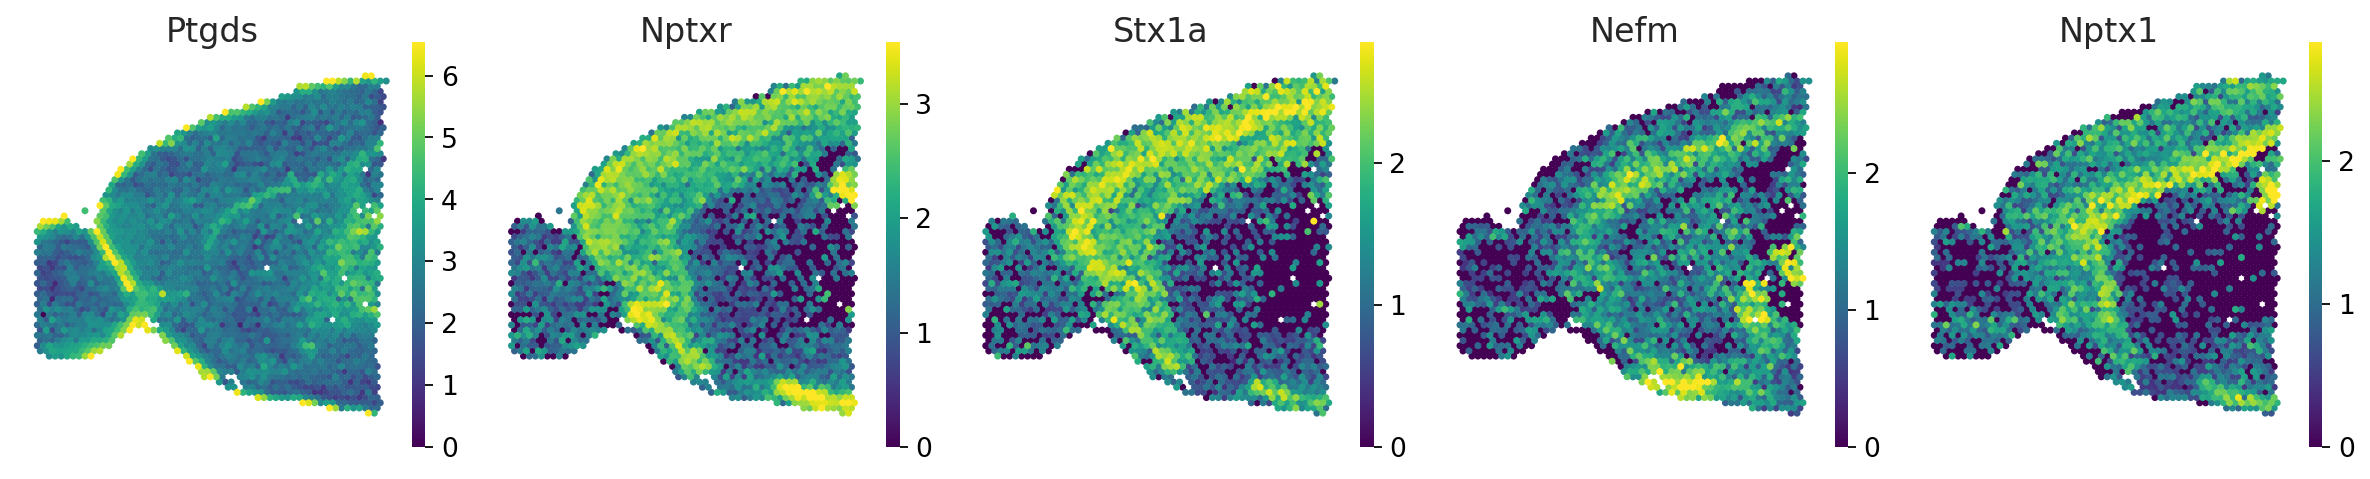

In [37]:
markers = ['Ptgds', 'Nptxr', 'Stx1a', 'Nefm', 'Nptx1']
sc.set_figure_params(vector_friendly=True, dpi_save=300, fontsize=12)

fig, axs = plt.subplots(1, 5, figsize=(15, 3))
axs = axs.flatten()
for a in axs:
    a.axis('off')
plt.subplots_adjust(hspace=0.1, wspace=0.1, left=0.05, right=0.95, top=0.95, bottom=0.05)
for idx, c in enumerate(markers):
    sc.pl.spatial(adata, cmap='viridis',
                  color=c, alpha_img=0,
                  ncols=4, size=1.8,
                  img_key='hires',
                  vmin=0, vmax='p99.2', ax=axs[idx], show=False
                  )
    axs[idx].set_title(f'{markers[idx]}', fontsize=15)
    cbar = fig.axes[-1]
    cbar.set_frame_on(False)
    cbar.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.tight_layout()
plt.show()

In [38]:
def get_color_blend(adata, dim=8, hexcodes=None, seed=None, mode='aa', color_first='black'):
    # define PC colors
    if hexcodes is None:
        if dim > 8:
            hexcodes = generate_random_colors(num_colors=dim, min_distance=1 / dim * 0.5)
        else:
            hexcodes = ['#db5f57', '#dbc257', '#91db57', '#57db80', '#57d3db', '#5770db', '#a157db', '#db57b2']
            if seed is None:
                np.random.seed(len(adata))
            else:
                np.random.seed(seed)
            np.random.shuffle(hexcodes)
    else:
        assert len(hexcodes) >= dim

    # define colormaps
    cmaps = []
    if mode == 'aa':
        for d in range(dim):
            pc_cmap = color_to_color(color_first, hexcodes[d])
            pc_rgb = get_rgb_from_colormap(pc_cmap,
                                           vmin=min(adata.obsm['chr_aa'][:, d]),
                                           vmax=max(adata.obsm['chr_aa'][:, d]),
                                           value=adata.obsm['chr_aa'][:, d])
            cmaps.append(pc_rgb)

    elif mode == 'pca':
        for d in range(dim):
            pc_cmap = color_to_color(color_first, hexcodes[d])
            pc_rgb = get_rgb_from_colormap(pc_cmap,
                                           vmin=min(adata.obsm['chr_X_pca'][:, d]),
                                           vmax=max(adata.obsm['chr_X_pca'][:, d]),
                                           value=adata.obsm['chr_X_pca'][:, d])
            cmaps.append(pc_rgb)
    else:
        raise Exception
    cblend = mip_colors(cmaps[0], cmaps[1],)
    if len(cmaps) > 2:
        i = 2
        for cmap in cmaps[2:]:
            cblend = mip_colors(cblend, cmap,)
            i += 1
    return cblend

sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=1000)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.tsne(adata)

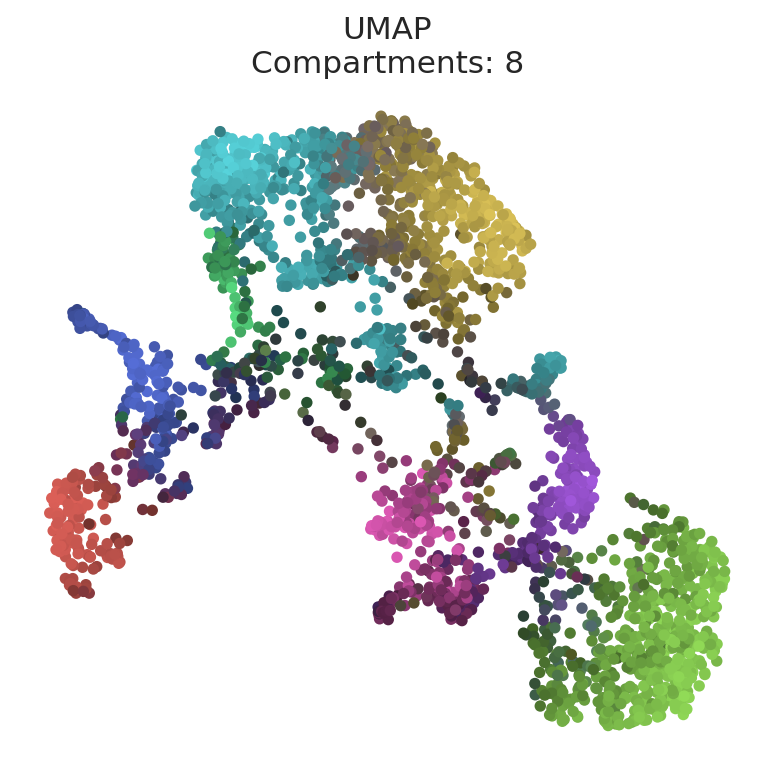

In [46]:
def color_to_color(first, last):
    # define the colors in the colormap
    colors = [first, last]
    # create a colormap object using the defined colors
    cmap = mcolors.LinearSegmentedColormap.from_list("", colors)
    return cmap


def get_rgb_from_colormap(cmap, vmin, vmax, value):
    # normalize the value within the range [0, 1]
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    value_normalized = norm(value)

    # get the RGBA value from the colormap
    rgba = plt.get_cmap(cmap)(value_normalized)
    # convert the RGBA value to RGB
    # color = tuple(np.array(rgba[:3]) * 255)
    color = np.array(rgba[:, :3])

    return color


def mip_colors(colors_1, colors_2):
    # blend the colors using linear interpolation
    mip_color = []
    for i in range(len(colors_1)):
        r = max(colors_1[i][0], colors_2[i][0])
        g = max(colors_1[i][1], colors_2[i][1])
        b = max(colors_1[i][2], colors_2[i][2])
        mip_color.append((r, g, b))
    return mip_color


ch.aa(adata, n_pcs=20, n_archetypes=8)
cblend = get_color_blend(adata, dim=8)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.axis('off')
ax.scatter(adata.obsm['X_umap'][:, 0], adata.obsm['X_umap'][:, 1],
            c=cblend, s=17, rasterized=True)
ax.set_title('UMAP\nCompartments: 8', fontsize=14)
plt.tight_layout()
plt.show()

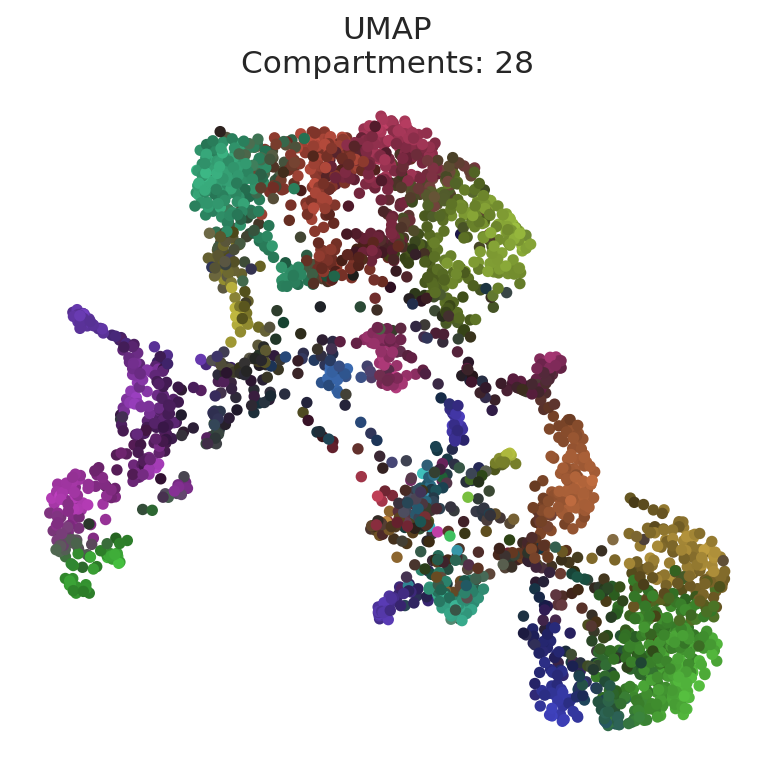

In [47]:
ch.aa(adata, n_pcs=20, n_archetypes=28)
cblend = get_color_blend(adata, dim=28)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.axis('off')
ax.scatter(adata.obsm['X_umap'][:, 0], adata.obsm['X_umap'][:, 1],
            c=cblend, s=17)
ax.set_title('UMAP\nCompartments: 28', fontsize=14)
plt.tight_layout()
plt.show()